### SMOTE (Synthetic Minority Oversampling Technique)

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

#### Start a simple Spark Session

In [3]:

# Initialize Spark session with increased configuration limits
spark = SparkSession.builder \
    .appName("RandomForestFraudDetection") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/11 12:06:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark = SparkSession.builder.appName('fraud_detection_smote').master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/11 11:20:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
col_names = ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 
'Merchant State', 'MCC', 'Errors?', 'Is Fraud?', 'Hour', 'Minute', 'Date', 'Day_of_Week']

df = spark.read.option("delimiter", "|").csv('df_EDA.csv', header=None, inferSchema=True).toDF(*col_names)
df = df.repartition(10)

24/06/11 12:07:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
r_300k_df = df.sample(withReplacement=False, fraction=1.0, seed=42).limit(300000)

In [6]:
Normal = r_300k_df[r_300k_df['Is Fraud?'] == 0]
# Normal.groupBy('Is Fraud?').count().show()

In [7]:
Fraud = df[df['Is Fraud?'] == 1]
# Fraud.groupBy('Is Fraud?').count().show()

In [8]:
df_smote_spark = Normal.union(Fraud)
# df_smote_spark.show(3)

In [9]:
stages = []
categorical_cols = ['Use Chip', 'Day_of_Week']
numerical_cols = ['Card', 'Year', 'Month', 'Day', 'Amount', 'MCC', 'Hour', 'Minute']

# Indexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_indexed') for col in categorical_cols]
# Encoders for categorical columns
encoders = [OneHotEncoder(inputCol=col+'_indexed', outputCol=col+'_OHE') for col in categorical_cols]

assembler = VectorAssembler(inputCols=(numerical_cols + ['Use Chip_OHE', 'Day_of_Week_OHE']),
                            outputCol='features')

# lr_model = LogisticRegression(featuresCol='features', labelCol='Is Fraud?')

stages = indexers + encoders + [assembler]

In [10]:
pipeline = Pipeline(stages=stages)
df_smote_spark = pipeline.fit(df_smote_spark).transform(df_smote_spark)

In [11]:
pandas_df = df_smote_spark.select('features', 'Is Fraud?').toPandas()

/Users/hakan/.venv/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [12]:
len(pandas_df['features'][0])

16

In [13]:
# Separate features and labels
X = np.array(pandas_df["features"].tolist())
y = pandas_df["Is Fraud?"]

In [14]:
X[0]

array([1.000e+00, 2.003e+03, 1.000e+01, 2.700e+01, 5.921e+01, 4.784e+03,
       9.000e+00, 5.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00])

In [15]:
# Apply SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
X_resampled.shape

(599342, 16)

In [17]:
y_resampled.shape

(599342,)

In [18]:
# Convert back to Spark DataFrame
resampled_data = [Row(features=Vectors.dense(X_resampled[i]), label=int(y_resampled[i])) for i in range(len(y_resampled))]
resampled_df = spark.createDataFrame(resampled_data)

In [19]:
# resampled_df.show(3)

In [20]:
# Split the data into training and test sets
train, test = resampled_df.randomSplit([0.8, 0.2], seed=42)

In [21]:
# Repartition the training data to increase the number of partitions
train = train.repartition(200)  # Adjust the number of partitions based on your cluster size


### Logistic Regression

In [29]:
lr_smote = LogisticRegression(featuresCol='features', labelCol='label')

In [30]:
fit_smote_model = lr_smote.fit(train)

24/06/11 11:09:43 WARN TaskSetManager: Stage 50 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:09:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/11 11:09:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/11 11:09:45 WARN TaskSetManager: Stage 52 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:09:46 WARN TaskSetManager: Stage 54 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:09:46 WARN TaskSetManager: Stage 56 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:09:46 WARN TaskSetManager: Stage 58 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:09:46 WARN TaskSetManager: Stage 60 contains a task of v

In [31]:
test.groupBy('label').count().show()

24/06/11 11:09:49 WARN TaskSetManager: Stage 82 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.


+-----+-----+
|label|count|
+-----+-----+
|    0|59989|
|    1|59878|
+-----+-----+



In [32]:
predictions = fit_smote_model.transform(test)

In [33]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Compute AUC
auc = evaluator.evaluate(predictions)
print(f'Test AUC: {auc}')

24/06/11 11:09:57 WARN TaskSetManager: Stage 85 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.


Test AUC: 0.8428888739046918


In [34]:
# Calculate confusion matrix manually
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().na.fill(0).orderBy("label")
confusion_matrix.show()

24/06/11 11:10:02 WARN TaskSetManager: Stage 96 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/11 11:10:03 WARN TaskSetManager: Stage 104 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.


+-----+-----+-----+
|label|  0.0|  1.0|
+-----+-----+-----+
|    0|51019| 8970|
|    1|17791|42087|
+-----+-----+-----+



In [26]:
# Convert confusion matrix to array for visualization
cm_array = confusion_matrix.collect()
print(f"cm_array1: {cm_array}")
cm_array = [row.asDict().values() for row in cm_array]
print(f"cm_array2: {cm_array}")
cm_array = [list(row)[1:] for row in cm_array]
print(f"cm_array3: {cm_array}")

24/06/10 19:17:51 WARN TaskSetManager: Stage 119 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.


cm_array1: [Row(label=0, 0.0=51039, 1.0=8950), Row(label=1, 0.0=17850, 1.0=42028)]
cm_array2: [dict_values([0, 51039, 8950]), dict_values([1, 17850, 42028])]
cm_array3: [[51039, 8950], [17850, 42028]]


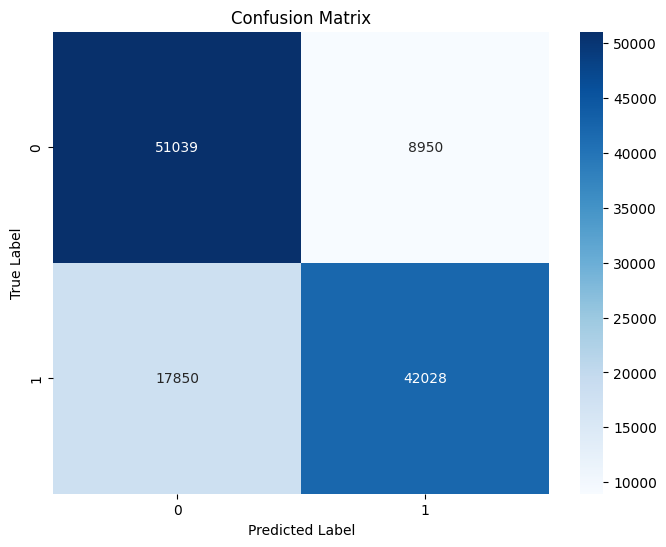

In [27]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_array, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision_label_0 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 0.0})
precision_label_1 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 1.0})

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall_label_0 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 0.0})
recall_label_1 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 1.0})

f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

print(f"Precision label 1: {precision_label_1}")
print(f"Recall label 1: {recall_label_1}")

print(f"Precision label 0: {precision_label_0}")
print(f"Recall label 0: {recall_label_0}")

24/06/10 19:17:52 WARN TaskSetManager: Stage 132 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:53 WARN TaskSetManager: Stage 134 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:54 WARN TaskSetManager: Stage 136 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:54 WARN TaskSetManager: Stage 138 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:55 WARN TaskSetManager: Stage 140 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:56 WARN TaskSetManager: Stage 142 contains a task of very large size (11617 KiB). The maximum recommended task size is 1000 KiB.
24/06/10 19:17:57 WARN TaskSetManager: Stage 144 contains a task of very large size (11617 KiB). The maximum recommended task size is 10

Accuracy: 0.7764188642412007
F1 Score: 0.7751638167424675
Precision label 1: 0.8244340695986504
Recall label 1: 0.7018938508300211
Precision label 0: 0.740887514697557
Recall label 0: 0.8508059810965344


### Decision Tree

In [25]:
# Define the Decision Tree model
dt_smote = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=42)

In [26]:
# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [27]:
dt_model = dt_smote.fit(train)
predictions = dt_model.transform(test)

In [28]:
# Evaluate the model
auc = evaluator.evaluate(predictions)

# Print the evaluation metric
print(f"AUC-ROC: {auc}")

AUC-ROC: 0.9148521521560415


In [29]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})


evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision_label_0 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 0.0})
precision_label_1 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 1.0})

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall_label_0 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 0.0})
recall_label_1 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 1.0})


f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

print(f"Precision label 1: {precision_label_1}")
print(f"Recall label 1: {recall_label_1}")

print(f"Precision label 0: {precision_label_0}")
print(f"Recall label 0: {recall_label_0}")

Accuracy: 0.8987034035656402
F1 Score: 0.8986958659302829
Precision label 1: 0.8916757005354621
Recall label 1: 0.9075513649965729
Precision label 0: 0.905977965179543
Recall label 0: 0.8898648987157863


### Random Forest With GridSearch CV

In [20]:
# Define the Random Forest model
rf_smote = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

In [21]:
# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

### GridSearch CV

In [25]:
# # Define the parameter grid for hyperparameter tuning
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf_smote.numTrees, [10, 20, 30]) \
#     .addGrid(rf_smote.maxDepth, [5, 10, 15]) \
#     .addGrid(rf_smote.maxBins, [32, 64]) \
#     .build()

# # Define CrossValidator
# crossval = CrossValidator(estimator=rf_smote,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)

# # Fit the model using CrossValidator
# cv_model = crossval.fit(train)

# # Make predictions
# predictions = cv_model.transform(test)

# # Extract the best model from CrossValidator
# best_model = cv_model.bestModel

# # Print out the best parameters
# print(f"Best numTrees: {best_model.stages[-1]._java_obj.getNumTrees()}")
# print(f"Best maxDepth: {best_model.stages[-1]._java_obj.getMaxDepth()}")
# print(f"Best maxBins: {best_model.stages[-1]._java_obj.getMaxBins()}")

In [22]:
train.select('features').head()

Row(features=DenseVector([0.0, 2010.0, 7.0, 31.0, 21.14, 5813.0, 21.0, 45.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]))

In [23]:
rf_model = rf_smote.fit(train)
predictions = rf_model.transform(test)

In [24]:
# Evaluate the model
auc = evaluator.evaluate(predictions)

# Print the evaluation metric
print(f"AUC-ROC: {auc}")

AUC-ROC: 0.9497392058163074


In [26]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Compute metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})


evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision_label_0 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 0.0})
precision_label_1 = evaluator_precision.evaluate(predictions, {evaluator_precision.metricLabel: 1.0})

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall_label_0 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 0.0})
recall_label_1 = evaluator_recall.evaluate(predictions, {evaluator_recall.metricLabel: 1.0})


f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

print(f"Precision label 1: {precision_label_1}")
print(f"Recall label 1: {recall_label_1}")

print(f"Precision label 0: {precision_label_0}")
print(f"Recall label 0: {recall_label_0}")

Accuracy: 0.881226085648883
F1 Score: 0.8811983558497514
Precision label 1: 0.8929679420889348
Recall label 1: 0.8661417322834646
Precision label 0: 0.870180615454457
Recall label 0: 0.8962943170621733
